In [1]:
import re

In [2]:
from tqdm import tqdm

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import plotly.express as px

In [6]:
import matplotlib.pyplot as plt

In [7]:
import seaborn as sns

In [8]:
import nltk

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     s:\anacondaprogramdata\anaconda3\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
from nltk.corpus import stopwords

In [11]:
from nltk.stem import WordNetLemmatizer

In [12]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     s:\anacondaprogramdata\anaconda3\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
from sklearn.metrics import classification_report,average_precision_score,accuracy_score, precision_recall_curve, classification_report

In [80]:
from sklearn.metrics import accuracy_score, f1_score

In [16]:
from focal_loss import BinaryFocalLoss

In [17]:
import tensorflow as tf

In [18]:
from tensorflow.keras.models import Model

In [19]:
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, concatenate, LSTM

In [20]:
from tensorflow.keras.utils import plot_model

In [21]:
from tensorflow.keras.regularizers import l2

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
from tensorflow.keras.utils import to_categorical

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [27]:
import warnings 
warnings.filterwarnings('ignore')

In [28]:
early_stopping = EarlyStopping(mode='min',patience=5)

In [74]:
df = pd.read_csv("Dataset/train.csv")

In [30]:
df["abstract"] = df['TITLE']+df['ABSTRACT']

In [31]:
seqlen_title=df['TITLE'].apply(lambda x: len(x.split()))

In [32]:
charlen_title=df['TITLE'].apply(lambda x: len(x))

In [33]:
seqlen_abstract=df['ABSTRACT'].apply(lambda x: len(x.split()))

In [34]:
charlen_abstract=df['ABSTRACT'].apply(lambda x: len(x))

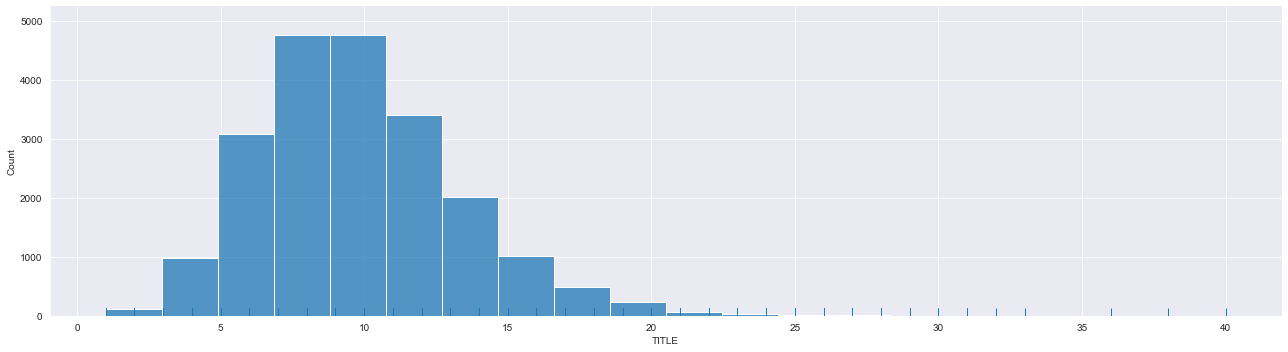

In [35]:
sns.set_style("darkgrid")
sns.displot(seqlen_title,bins=20,palette="bright",rug=True, height=5, aspect=3.6);

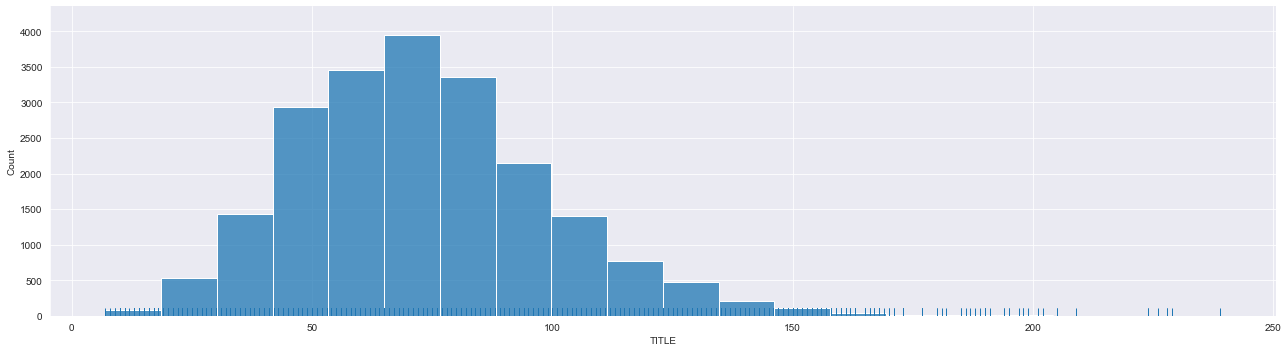

In [36]:
sns.set_style("darkgrid")
sns.displot(charlen_title,bins=20,palette="bright",rug=True, height=5, aspect=3.6);

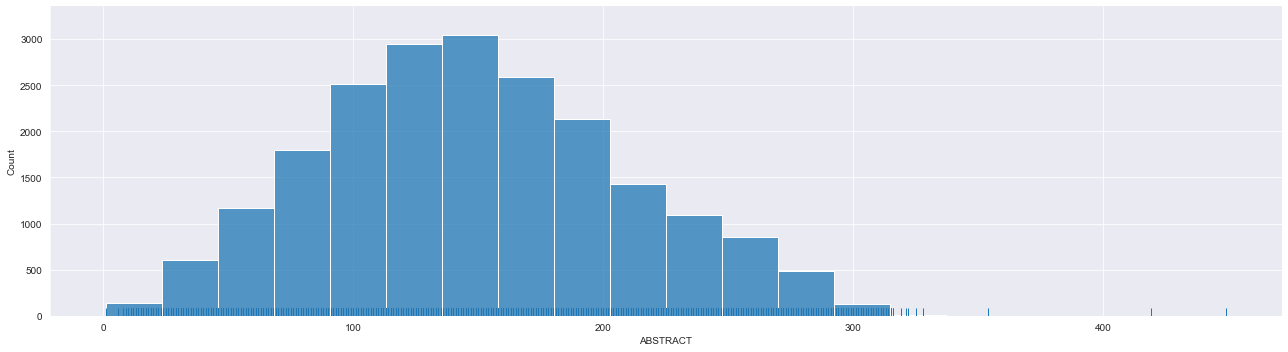

In [37]:
sns.set_style("darkgrid")
sns.displot(seqlen_abstract,bins=20,palette="bright",rug=True, height=5, aspect=3.6);

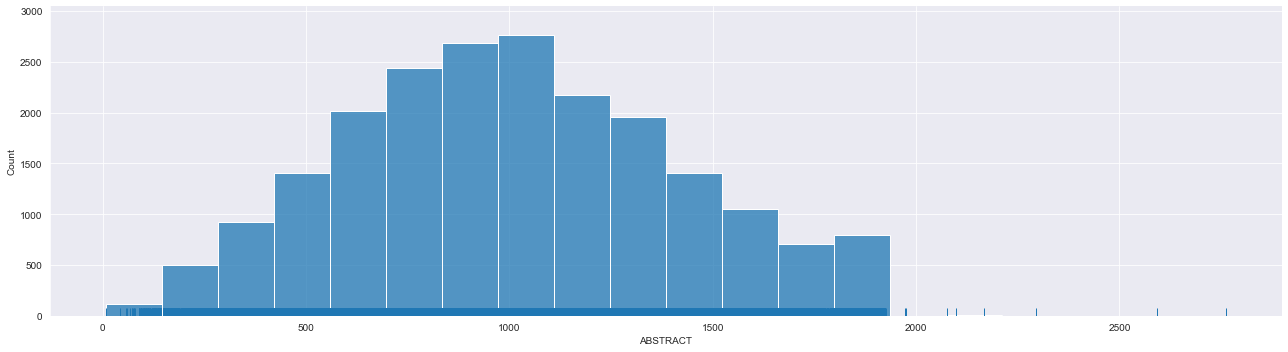

In [38]:
sns.set_style("darkgrid")
sns.displot(charlen_abstract,bins=20,palette="bright",rug=True, height=5, aspect=3.6);

In [39]:
X = df['abstract']

In [40]:
y = df.iloc[:,3:-1]

In [41]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [42]:
print("X_train Size : {} ".format(X_train.shape))
print("y_train Size : {} ".format(y_train.shape))
print("X_test Size : {} ".format(X_test.shape))
print("y_test Size : {} ".format(y_test.shape))

X_train Size : (16777,) 
y_train Size : (16777, 6) 
X_test Size : (4195,) 
y_test Size : (4195, 6) 


In [43]:
class TextCleaning:
    def __init__(self,text):
        self.stop_words = stopwords.words('english')
        self.lemma = WordNetLemmatizer()
        self.token = Tokenizer()
        self.clean_data = list()
        for sentence in tqdm(text):
            sentence = self.remove_punctuations(sentence)
            sentence = self.stop_word_remover(sentence)
            sentence = self.lemmatization(sentence)
            self.clean_data.append(sentence)            
        self.token_sentence = self.tokenization(self.clean_data)
        
    def remove_punctuations(self,text):
        text = text.lower()
        text  = re.findall("[a-zA-Z]+",text)
        return text

    def stop_word_remover(self,text):
        text = [w for w in text if not w in self.stop_words]
        return text
    
    def lemmatization(self,text):
        text = " ".join(self.lemma.lemmatize(w) for w in  text)
        return text
    
    def tokenization(self,text):
        self.token.fit_on_texts(text)
        text = self.token.texts_to_sequences(text)
        return text

In [44]:
pre_train = TextCleaning(X_train)
pre_test = TextCleaning(X_test)

100%|████████████████████████████████████████████████████████████████████████████| 4195/4195 [00:02<00:00, 1687.80it/s]


In [45]:
len_seq = list()
for i in range(0,len(pre_train.token_sentence)):
    len_seq.append(len(pre_train.token_sentence[i]))

In [46]:
max_len_seq = max(len_seq)

In [47]:
X_train_seq = pad_sequences(pre_train.token_sentence,maxlen = max_len_seq,padding = 'pre',truncating='post')

In [48]:
X_test_seq = pad_sequences(pre_test.token_sentence,maxlen = max_len_seq,padding = 'pre',truncating='post')

In [49]:
vocab_size = len(pre_train.token.word_index) + 1

In [56]:
def create_semantic_interactive_learning_model(layer_type="rnn"):
    inputs_layer = Input(shape=(None,), name="input")
    x = Embedding(vocab_size, 300, input_length = max_len_seq, trainable = False)(inputs_layer)
    if layer_type == "rnn":
        x = SimpleRNN(64,kernel_regularizer=l2(0.01),activity_regularizer=l2(0.01))(x)
    else:
        x = LSTM(64,kernel_regularizer=l2(0.01),activity_regularizer=l2(0.01))(x)
    cs_pred = Dense(1, activation='sigmoid',name='CS',kernel_regularizer=l2(0.01),activity_regularizer=l2(0.01))(x)
    ph_pred = Dense(1, activation='sigmoid',name='PH',kernel_regularizer=l2(0.01),activity_regularizer=l2(0.01))(x)
    math_pred = Dense(1, activation='sigmoid',name='MATH',kernel_regularizer=l2(0.01),activity_regularizer=l2(0.01))(x)
    stat_pred = Dense(1, activation='sigmoid',name='STAT',kernel_regularizer=l2(0.01),activity_regularizer=l2(0.01))(x)
    qb_pred = Dense(1, activation='sigmoid',name='QB',kernel_regularizer=l2(0.01),activity_regularizer=l2(0.01))(x)
    qf_pred = Dense(1, activation='sigmoid',name='QF',kernel_regularizer=l2(0.01),activity_regularizer=l2(0.01))(x)
    model = Model(inputs=[inputs_layer],outputs=[cs_pred,ph_pred,math_pred,stat_pred,qb_pred,qf_pred])
    return model

In [57]:
model = create_semantic_interactive_learning_model()

In [58]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, None, 300)    12431100    ['input[0][0]']                  
                                                                                                  
 simple_rnn_1 (SimpleRNN)       (None, 64)           23360       ['embedding_3[0][0]']            
                                                                                                  
 CS (Dense)                     (None, 1)            65          ['simple_rnn_1[0][0]']           
                                                                                              

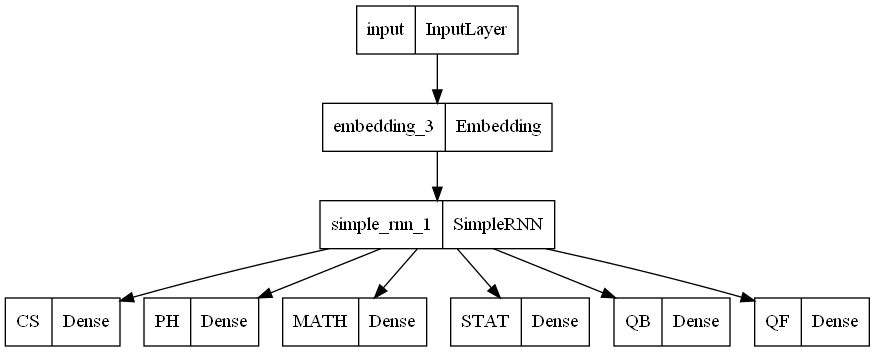

In [59]:
plot_model(model,"semantic_interactive_learning_rnn_model.png")

In [60]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=BinaryFocalLoss(gamma=2),
    metrics=['accuracy'],)

In [61]:
no_of_epochs = 3

In [62]:
history = model.fit({"input": X_train_seq,}, 
                    {'CS': y_train.iloc[:,0], 'PH':y_train.iloc[:,1], 'MATH': y_train.iloc[:,2], 'STAT': y_train.iloc[:,3], 'QB': y_train.iloc[:,4], 'QF': y_train.iloc[:,5]},
                    epochs = no_of_epochs, 
                    validation_data =({"input": X_test_seq} ,
                                     {'CS': y_test.iloc[:,0], 'PH':y_test.iloc[:,1], 'MATH': y_test.iloc[:,2], 'STAT': y_test.iloc[:,3], 'QB': y_test.iloc[:,4], 'QF': y_test.iloc[:,5]}),
                    callbacks=early_stopping,
                    verbose=True
                   )

Epoch 1/3
525/525 [==============================] - 28s 42ms/step - loss: 0.9259 - CS_loss: 0.1701 - PH_loss: 0.1528 - MATH_loss: 0.1478 - STAT_loss: 0.1435 - QB_loss: 0.0409 - QF_loss: 0.0256 - CS_accuracy: 0.5857 - PH_accuracy: 0.7098 - MATH_accuracy: 0.7326 - STAT_accuracy: 0.7512 - QB_accuracy: 0.9678 - QF_accuracy: 0.9831 - val_loss: 0.7396 - val_CS_loss: 0.1691 - val_PH_loss: 0.1533 - val_MATH_loss: 0.1504 - val_STAT_loss: 0.1450 - val_QB_loss: 0.0406 - val_QF_loss: 0.0220 - val_CS_accuracy: 0.5967 - val_PH_accuracy: 0.7077 - val_MATH_accuracy: 0.7259 - val_STAT_accuracy: 0.7452 - val_QB_accuracy: 0.9709 - val_QF_accuracy: 0.9893
Epoch 2/3
525/525 [==============================] - 25s 48ms/step - loss: 0.7206 - CS_loss: 0.1697 - PH_loss: 0.1519 - MATH_loss: 0.1476 - STAT_loss: 0.1431 - QB_loss: 0.0382 - QF_loss: 0.0222 - CS_accuracy: 0.5886 - PH_accuracy: 0.7147 - MATH_accuracy: 0.7337 - STAT_accuracy: 0.7534 - QB_accuracy: 0.9723 - QF_accuracy: 0.9878 - val_loss: 0.7157 - val_

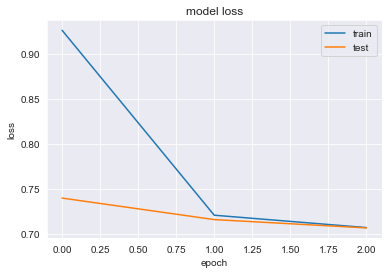

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [64]:
model = create_semantic_interactive_learning_model("lstm")

In [65]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, None, 300)    12431100    ['input[0][0]']                  
                                                                                                  
 lstm (LSTM)                    (None, 64)           93440       ['embedding_4[0][0]']            
                                                                                                  
 CS (Dense)                     (None, 1)            65          ['lstm[0][0]']                   
                                                                                            

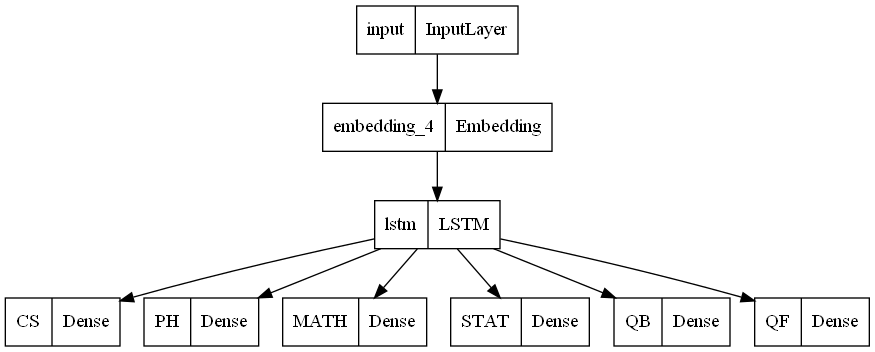

In [66]:
plot_model(model,"semantic_interactive_learning_lstm_model.png")

In [67]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=BinaryFocalLoss(gamma=2),
    metrics=['accuracy'],)

In [68]:
history = model.fit({"input": X_train_seq,}, 
                    {'CS': y_train.iloc[:,0], 'PH':y_train.iloc[:,1], 'MATH': y_train.iloc[:,2], 'STAT': y_train.iloc[:,3], 'QB': y_train.iloc[:,4], 'QF': y_train.iloc[:,5]},
                    epochs = no_of_epochs, 
                    validation_data =({"input": X_test_seq} ,
                                     {'CS': y_test.iloc[:,0], 'PH':y_test.iloc[:,1], 'MATH': y_test.iloc[:,2], 'STAT': y_test.iloc[:,3], 'QB': y_test.iloc[:,4], 'QF': y_test.iloc[:,5]}),
                    callbacks=early_stopping,
                    verbose=True
                   )

Epoch 1/3
525/525 [==============================] - 50s 90ms/step - loss: 0.9219 - CS_loss: 0.1702 - PH_loss: 0.1529 - MATH_loss: 0.1487 - STAT_loss: 0.1442 - QB_loss: 0.0417 - QF_loss: 0.0262 - CS_accuracy: 0.5841 - PH_accuracy: 0.7103 - MATH_accuracy: 0.7315 - STAT_accuracy: 0.7519 - QB_accuracy: 0.9707 - QF_accuracy: 0.9849 - val_loss: 0.7283 - val_CS_loss: 0.1701 - val_PH_loss: 0.1533 - val_MATH_loss: 0.1501 - val_STAT_loss: 0.1452 - val_QB_loss: 0.0391 - val_QF_loss: 0.0199 - val_CS_accuracy: 0.5967 - val_PH_accuracy: 0.7077 - val_MATH_accuracy: 0.7259 - val_STAT_accuracy: 0.7452 - val_QB_accuracy: 0.9709 - val_QF_accuracy: 0.9893
Epoch 2/3
525/525 [==============================] - 53s 101ms/step - loss: 0.7160 - CS_loss: 0.1699 - PH_loss: 0.1520 - MATH_loss: 0.1478 - STAT_loss: 0.1431 - QB_loss: 0.0381 - QF_loss: 0.0220 - CS_accuracy: 0.5886 - PH_accuracy: 0.7147 - MATH_accuracy: 0.7337 - STAT_accuracy: 0.7534 - QB_accuracy: 0.9723 - QF_accuracy: 0.9878 - val_loss: 0.7147 - val

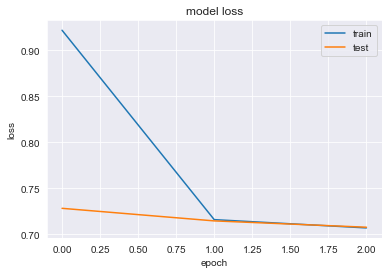

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [70]:
preds = model.predict(X_test_seq)

132/132 [==============================] - 6s 43ms/step


In [88]:
result = model.evaluate(X_test_seq, y_test)

132/132 [==============================] - 5s 39ms/step - loss: 1.0202 - CS_loss: 0.1537 - PH_loss: 0.1373 - MATH_loss: 0.1365 - STAT_loss: 0.1335 - QB_loss: 0.2000 - QF_loss: 0.2267 - CS_accuracy: 0.7893 - PH_accuracy: 0.7893 - MATH_accuracy: 0.7893 - STAT_accuracy: 0.7893 - QB_accuracy: 0.7893 - QF_accuracy: 0.7893


In [89]:
result

[1.0201973915100098,
 0.1537475287914276,
 0.13727273046970367,
 0.13647887110710144,
 0.1334669291973114,
 0.2000381499528885,
 0.22672773897647858,
 0.7892730236053467,
 0.7892730236053467,
 0.7892730236053467,
 0.7892730236053467,
 0.7892730236053467,
 0.7892730236053467]